### Monitoring of the water extent of Lake Neusiedl and the Lacken:

#### Libraries

In [1]:
import os
import glob
from osgeo import gdal
import pprint
import numpy as np
import matplotlib.pyplot as plt
from yeoda.datacube import DataCubeReader,DataCubeWriter
from geopathfinder.naming_conventions.yeoda_naming import YeodaFilename
import pandas as pd
import time
import rasterio
import glob
from rasterio.plot import show
import rasterio
import numpy as np
from rasterio.merge import merge
from rasterio.plot import show
from osgeo import gdal
from data_func import  merge_files_and_split
import warnings
import numpy as np
import glob
from six.moves import xrange
import scipy.ndimage as ndi
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import img_to_array 
from torch.utils.data import TensorDataset, DataLoader, Dataset

import shutil

from PIL import Image, ImageOps, ImageFile


In [2]:
# pip install scipy

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)




#### Reading Data

In [4]:
tile_1 = r"./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N015T1"
tile_1 = glob.glob(os.path.join(tile_1, "*"))

In [5]:
tile_2 = r"./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N015T1"
tile_2 = glob.glob(os.path.join(tile_2, "*"))

In [6]:

mask1 = r"./e11739391/reference/EQUI7_EU010M/E052N015T1"
mask1 = glob.glob(os.path.join(mask1, "*"))

mask2 = r"./e11739391/reference/EQUI7_EU010M/E053N015T1"
mask2 = glob.glob(os.path.join(mask2, "*"))

In [7]:

dimensions = ["time", "tile_name", "var_name", "sensor_field", "data_version"]
tile1_reader = DataCubeReader.from_filepaths(tile_1, fn_class=YeodaFilename, dimensions=dimensions,
                                             stack_dimension="time", tile_dimension="tile_name")
tile1_reader.file_register.head(5)

,filepath,sensor_field,var_name,tile_name,data_version,time
0,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,GMR40,E053N015T1,V1M0R01,2022-09-22 16:42:50
1,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,GMR40,E053N015T1,V1M0R01,2022-01-17 05:02:29
2,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,GMR40,E053N015T1,V1M0R01,2022-06-10 05:02:33
3,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,GMR40,E053N015T1,V1M0R01,2022-04-11 05:02:29
4,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,GMR40,E053N015T1,V1M0R01,2022-12-07 05:02:12


In [8]:

tile2_reader = DataCubeReader.from_filepaths(tile_2, fn_class=YeodaFilename, dimensions=dimensions,
                                             stack_dimension="time", tile_dimension="tile_name")
tile2_reader.file_register.head(5)

,filepath,sensor_field,var_name,tile_name,data_version,time
0,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,S1AIWGRDH,GMR40,E052N015T1,V1M0R01,2022-06-10 05:02:08
1,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,S1AIWGRDH,GMR40,E052N015T1,V1M0R01,2022-12-07 05:02:37
2,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,S1AIWGRDH,GMR40,E052N015T1,V1M0R01,2022-10-20 05:02:13
3,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,S1AIWGRDH,GMR40,E052N015T1,V1M0R01,2022-02-10 05:02:04
4,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E052N...,S1AIWGRDH,GMR40,E052N015T1,V1M0R01,2022-03-06 05:02:03


In [9]:
tile1_reader.file_register.sort_values(by = 'time')['time'].unique()

<DatetimeArray>
['2022-01-17 05:02:04', '2022-01-17 05:02:29', '2022-02-10 05:02:04',
 '2022-02-10 05:02:29', '2022-03-06 05:02:03', '2022-03-06 05:02:28',
 '2022-04-11 05:02:04', '2022-04-11 05:02:29', '2022-05-17 05:02:05',
 '2022-05-17 05:02:30', '2022-06-10 05:02:08', '2022-06-10 05:02:33',
 '2022-07-24 16:42:48', '2022-07-24 16:43:13', '2022-08-05 16:42:49',
 '2022-08-05 16:43:14', '2022-09-22 16:42:50', '2022-09-22 16:43:15',
 '2022-10-20 05:02:13', '2022-10-20 05:02:38', '2022-11-01 05:02:13',
 '2022-11-01 05:02:38', '2022-12-07 05:02:12', '2022-12-07 05:02:37']
Length: 24, dtype: datetime64[ns]

In [10]:
mask1_reader = DataCubeReader.from_filepaths(mask1, fn_class=YeodaFilename, dimensions=dimensions,
                                             stack_dimension="time", tile_dimension="tile_name")
mask2_reader = DataCubeReader.from_filepaths(mask2, fn_class=YeodaFilename, dimensions=dimensions,
                                             stack_dimension="time", tile_dimension="tile_name")

In [11]:
mask2_reader.file_register.head(5)

,filepath,sensor_field,var_name,tile_name,data_version,time
0,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,None,MASK,E053N015T1,None,2022-08-05
1,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,None,MASK,E053N015T1,None,2022-01-17
2,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,None,MASK,E053N015T1,None,2022-04-11
3,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,None,MASK,E053N015T1,None,2022-09-22
4,./e11739391/reference/EQUI7_EU010M/E053N015T1/...,None,MASK,E053N015T1,None,2022-07-24


In [12]:
mask1_reader.file_register.head(5)

,filepath,sensor_field,var_name,tile_name,data_version,time
0,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,None,MASK,E052N015T1,None,2022-05-17
1,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,None,MASK,E052N015T1,None,2022-01-17
2,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,None,MASK,E052N015T1,None,2022-10-20
3,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,None,MASK,E052N015T1,None,2022-12-07
4,./e11739391/reference/EQUI7_EU010M/E052N015T1/...,None,MASK,E052N015T1,None,2022-05-17


#### Merging files

In [15]:
df_concat = pd.concat([tile1_reader.file_register, tile2_reader.file_register], axis=0)

In [16]:
df_concat.head(5)

,filepath,sensor_field,data_version,var_name,tile_name,time
0,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,V1M0R01,GMR40,E053N015T1,2022-09-22 16:42:50
1,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,V1M0R01,GMR40,E053N015T1,2022-01-17 05:02:29
2,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,V1M0R01,GMR40,E053N015T1,2022-06-10 05:02:33
3,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,V1M0R01,GMR40,E053N015T1,2022-04-11 05:02:29
4,./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N...,S1AIWGRDH,V1M0R01,GMR40,E053N015T1,2022-12-07 05:02:12


In [15]:
merge_files_and_split(df_concat,'VV')

/Users/nadia/PycharmProjects/InterdisciplinaryProject/data_func.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped.loc[:, 'date'] = grouped['time'].dt.date


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [16]:
merge_files_and_split(df_concat,'VH')

0

/Users/nadia/PycharmProjects/InterdisciplinaryProject/data_func.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped.loc[:, 'date'] = grouped['time'].dt.date


...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [13]:
df_concat_mask= pd.concat([mask1_reader.file_register, mask2_reader.file_register], axis=0)

In [14]:
merge_files_and_split(df_concat_mask,notmask=False)

/Users/nadia/PycharmProjects/InterdisciplinaryProject/data_func.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped.loc[:, 'date'] = grouped['time'].dt.date


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...

### Reading merged data

In [104]:
path2 = "./train/VV_2022-01-17_merged.tiff"

In [105]:
path = "./e11739391/Sentinel-1_CSAR/EQUI7_EU010M/E053N015T1/GMR40_20220411T050204__VV_D124_E053N015T1_EU010M_V1M0R01_S1AIWGRDH.tif"

x =rasterio.open(path2)

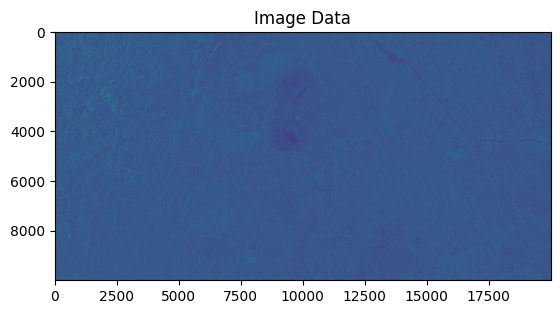

In [106]:
image_data= x.read(1)
plt.imshow(image_data)
plt.title("Image Data")
plt.show()

In [107]:
# Image.MAX_IMAGE_PIXELS = None
# ImageFile.LOAD_TRUNCATED_IMAGES = True

In [15]:
train = "./train/*.tiff"
mask_train = "./train_mask/*.tiff"
img_list = sorted(glob.glob(train))
mask_list = sorted(glob.glob(mask_train))

In [16]:
file_num = len(img_list)
output_filename = './try.txt'
with open(output_filename, 'w') as f:
    for s in range(file_num):
        print(img_list[s][2:])
        f.write(img_list[s]+ '\t' + mask_list[s] + '\n' )

train/VH_2022-01-17_merged.tiff
train/VH_2022-02-10_merged.tiff
train/VH_2022-03-06_merged.tiff
train/VH_2022-06-10_merged.tiff
train/VH_2022-09-22_merged.tiff
train/VH_2022-10-20_merged.tiff
train/VH_2022-11-01_merged.tiff
train/VH_2022-12-07_merged.tiff
train/VV_2022-01-17_merged.tiff
train/VV_2022-02-10_merged.tiff
train/VV_2022-03-06_merged.tiff
train/VV_2022-06-10_merged.tiff
train/VV_2022-09-22_merged.tiff
train/VV_2022-10-20_merged.tiff
train/VV_2022-11-01_merged.tiff
train/VV_2022-12-07_merged.tiff


In [ ]:
import os
os.makedirs("./augmented_images",exist_ok=True)

In [ ]:
datagen = ImageDataGenerator( 
        rotation_range = 40, 
        shear_range = 0.2, 
        zoom_range = 0.2, 
        horizontal_flip = True, 
        brightness_range = (0.5, 1.5)) 

In [ ]:
img = Image.open("./train/" + l[1])

In [ ]:
l = os.listdir("./train/")
l[1]

In [ ]:
img_arr = img_to_array(img)
img_arr = img_arr.reshape((1,) + img_arr.shape)

i = 0
for batch in datagen.flow(
    img_arr,
    batch_size=1,
    save_to_dir='./augmented_images',
    save_prefix=l[1] +'_augemented' ,
    save_format='tif'):
    i += 1
    if i > 2: # create 20 augmented images
        break 

In [12]:
# pip install opencv-python==4.6.0.66

In [53]:
import cv2

In [192]:
class Images(Dataset):
    def __init__(self, image_path, mask_path ,transforms,train_mode = True):
        self.image_path = image_path
        self.transforms = transforms
        self.mask_path = mask_path
        self.train_mode = train_mode  
        
        print(len(self.image_path))
        # print(len(self.mask_path))
        
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, index):
        with rasterio.open(self.image_path[index]) as img_file:
            img = img_file.read(1)
            # print(img)# Read the first band
        
        with rasterio.open(self.mask_path[index]) as mask_file:
            mask = mask_file.read(1)  
            
        if self.transforms is not None:
                img = self.transforms(img)
                mask = self.transforms(mask)
                    
        return (img,mask)
    
        # return self.image_path[index],self.mask_path[index]

In [193]:
train = "./train/.tiff"
# mask_train = "./train_mask/*.tiff"
file = "./try/"
img_list = sorted(glob.glob('./train/*.tiff'))
mask_list = sorted(glob.glob('./train_mask/*.tiff'))


In [194]:
trainDS = Images(img_list,mask_list,transforms=None)

16


In [195]:
trainLoader = DataLoader(trainDS, shuffle=True,batch_size=16)

AxesImage(size=(10000, 20000))
AxesImage(size=(10000, 20000))


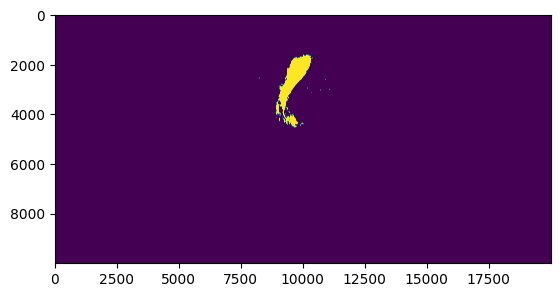

In [196]:
x,y= next(iter(trainLoader))
i = 0
for a,b in zip(x,y):
    print(plt.imshow(b))
    i+=1
    if (i==2):
        break

ValueError: only one element tensors can be converted to Python scalars

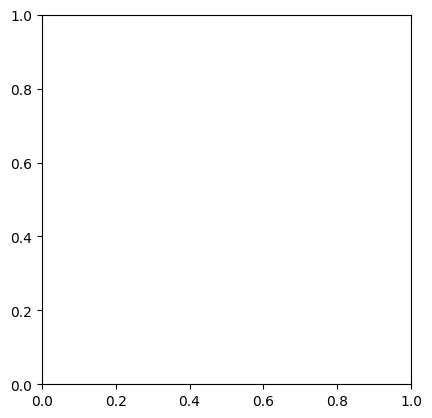

In [191]:
y= next(iter(trainLoader))
i = 0
for b in zip(y):
    print(plt.imshow(b))
    i+=1
    if (i==2):
        break